In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
from pprint import pprint

from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS

from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.psf import PSF

# Modeling COSMOS0018+3845

In [14]:
lens_table_path = os.path.join(repo_path, 'data', 'lens.fit')

with fits.open(lens_table_path) as hdu_list:
    hdu_list.verify()
    hdu_list.info()
    lens_table = Table(hdu_list[1].data)

Filename: /nfshome/bwedig/roman-pandeia/data/lens.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   ()      
  1  J_ApJS_176_19_table4    1 TableHDU        50   16R x 10C   [A9, F5.2, F5.2, F5.2, F5.1, F5.2, F5.2, F5.1, A9, A6]   


In [15]:
table_4_path = os.path.join(repo_path, 'data', 'table4.fit')

with fits.open(table_4_path) as hdu_list:
    hdu_list.verify()
    hdu_list.info()
    table_4 = Table(hdu_list[1].data)

Filename: /nfshome/bwedig/roman-pandeia/data/table4.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  J_ApJS_176_19_lens    1 TableHDU        85   67R x 19C   [A1, A9, A1, A10, A9, F5.2, F5.2, F5.2, F5.2, F5.2, F4.1, F5.2, F5.2, F5.2, F5.1, F5.2, F4.1, A1, I8]   


In [16]:
lens_table.show_in_notebook()

idx,COSMOS,zl,zs,chi2,sigV,Erad,gamma,theta,Images,Mult
0,0012+2015,0.41,0.95,0.01,215.3,0.67,0.0,0.0,no,Double
1,0018+3845,0.71,1.93,1.9,303.1,1.32,0.28,47.5,no,Triple
2,0038+4133,0.89,2.7,0.08,225.3,0.73,0.06,179.1,no,Ring
3,0047+5023,0.85,2.51,1.4,313.0,1.41,0.23,174.1,no,Triple
4,0049+5128,0.33,0.74,0.0,380.0,2.09,0.0,0.0,"no (1,2)",Ring
5,0050+4901,1.01,3.34,3.4,342.3,1.69,0.23,76.1,"no (2,3)",Quad
6,0056+1226,0.44,1.03,1.3,337.4,1.64,0.0,0.0,no,Double
7,0124+5121,0.84,2.47,0.0,245.0,0.86,0.0,0.0,no (1),Ring
8,0211+1139,0.9,2.76,0.01,466.3,3.14,0.0,0.0,no (2),Double
9,0216+2955,0.67,1.77,0.06,348.5,1.75,0.0,0.0,no (2),Double


In [17]:
table_4.show_in_notebook()

idx,n_COSMOS,COSMOS,f_COSMOS,RAJ2000,DEJ2000,zph,E_zph,e_zph_lc,r,reff,n,F814W,E_F814W,e_f814w_lc,PA,Ell,sb814W,C,recno
0,B,0012+2015,,10 00 12.6,+02 20 15,0.41,0.03,0.05,0.9,0.53,8.1,19.28,0.01,0.01,-10.2,0.25,21.6,C,1
1,b,0013+2249,,10 00 13.9,+02 22 49,0.38,0.06,0.02,1.65,0.9,3.9,18.89,0.01,0.01,38.2,0.16,22.4,C,2
2,B,0018+3845,f,10 00 18.4,+02 38 45,0.71,0.02,0.13,0.4,0.29,5.6,23.6,0.01,0.01,-21.8,0.23,22.7,C,3
3,B,0038+4133,,10 00 38.2,+02 41 33,0.89,0.05,0.03,0.74,0.72,5.2,20.39,0.05,0.05,-2.9,0.26,20.5,C,4
4,B,0047+5023,,10 00 47.6,+01 50 23,0.85,0.07,0.05,0.7,0.72,1.9,20.65,0.01,0.01,33.4,0.05,22.8,C,5
5,B,0049+5128,,10 00 49.2,+01 51 28,0.33,0.03,0.05,2.22,1.07,1.2,19.61,0.01,0.01,-24.6,0.22,23.3,C,6
6,B,0050+4901,f,10 00 50.6,+02 49 01,1.01,0.07,0.05,1.9,0.36,2.9,21.72,0.02,0.03,26.6,0.39,22.7,C,7
7,B,0056+1226,,10 00 56.7,+02 12 26,0.44,0.04,0.04,1.2,0.96,4.6,18.7,0.03,0.0,40.3,0.0,23.3,C,8
8,B,0124+5121,,10 01 24.5,+01 51 21,0.84,0.04,0.04,0.84,0.24,2.4,22.43,0.15,0.05,-51.4,0.25,23.2,C,9
9,B,0211+1139,,10 02 11.2,+02 11 39,0.9,0.06,0.04,3.2,0.74,4.1,21.09,0.06,0.09,11.0,0.35,21.6,C,10


* ra (h:m:s) 10:00:18.4
* dec (d:':") +02:38:45
* limiting magnitude F814W 26.5 mag
* output grid pixel size 0.03"
* size postage stamp 10"x10"
* 

In [3]:
z_lens = 0.71
z_source = 1.93
theta_E = 1.32
shear = 0.28
shear_orientation = 47.5

# lens light
r_eff = 0.29
n = 5.6
f814w_mag_lens = 23.60
position_angle = -21.8
ellipticity = 0.23

# image light
f814w_mag_source = 22.7

In [4]:
lens_model_list = ['SIE', 'SHEAR']

kwargs_spemd = {'theta_E': theta_E, 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0.}
kwargs_shear = {'gamma1': shear, 'gamma2': 0.}

kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list)

lens_light_model_list = ['SERSIC_ELLIPSE']

kwargs_sersic_lens = {'amp': 10, 'R_sersic': r_eff, 'n_sersic': n, 'e1': ellipticity, 'e2': 0., 'center_x': 0., 'center_y': 0.}

kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(lens_light_model_list)

source_model_list = ['SERSIC_ELLIPSE']

kwargs_sersic = {'amp': 10, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0.}

kwargs_source_light = [kwargs_sersic]
source_model_class = LightModel(source_model_list)

In [5]:
num_pix = 45
delta_pix = 0.11  # size of pixel in angular coordinates
ra_at_xy_0, dec_at_xy_0 = -delta_pix * math.ceil(num_pix / 2), -delta_pix * math.ceil(num_pix / 2) # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * delta_pix  # linear translation matrix of a shift in pixel in a shift in coordinates

kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)

kwargs_psf = {'psf_type': 'NONE'}
psf_class = PSF(**kwargs_psf)

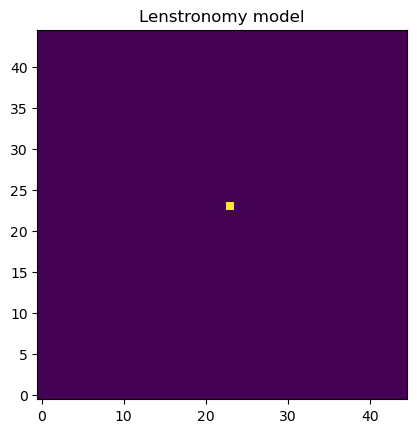

In [6]:
kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False}

imageModel = ImageModel(data_class=pixel_grid,
                        psf_class=psf_class,
                        lens_model_class=lens_model_class,
                        source_model_class=source_model_class,
                        lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

kwargs_model = {'lens_model_list': lens_model_list,
                'lens_light_model_list': lens_light_model_list,
                'source_light_model_list': source_model_list}

image = imageModel.image(kwargs_lens=kwargs_lens,
                         kwargs_source=kwargs_source_light,
                         kwargs_lens_light=kwargs_lens_light)

plt.imshow(image, origin='lower')
plt.title('Lenstronomy model')
# plt.savefig('figures/model.png')
plt.show()

In [7]:
# np.save('model', image)